In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

In [ ]:
def id(x):
    return x

function = type(id)

In [ ]:
def sqal(f, g):
    return (f * g).sum() / 2

def norm(f):
    return np.sqrt(sqal(f, f))

def int_01(f):
    return (f.sum() - f[0] / 2 - f[-1] / 2) / (len(f) - 1)

In [ ]:
def Fourier(f, N_coefs, N_points):
    coefs = []
    h = 1.0 / (N_points - 1)
    x = np.arange(0.0, 1.0 + h, h) * np.pi
    return np.array([int_01(f * np.sin(x * i)) * 2 for i in range(1, N_coefs + 1)])

def inverseFourier(coefs, N_points):
    h = 1.0 / (N_points - 1)
    x = np.arange(0.0, 1.0 + h, h) * np.pi
    f = np.zeros(N_points)
    for i in range(coefs.shape[0]):
        f += np.sin(x * (i + 1)) * coefs[i]
    return f

In [ ]:
def plot_Fourier(f, N_points, label):
    h = 1.0 / (N_points - 1)
    x = np.arange(0.0, 1.0 + h, h) 
    y = inverseFourier(f, N_points)
    plt.plot(x, y, label=label)

In [ ]:
class Oracle:
    def __init__(self, f, g, k, N_coefs, N_points):
        if type(f) == function:
            self.f = np.array([0.0] + [f(j / N_points) for j in range(1, N_points - 1)] + [0.0])
        else:
            self.f = f
        if type(g) == function:
            self.g = np.array([0.0] + [g(j / N_points) for j in range(1, N_points - 1)] + [0.0])
        else:
            self.g = g
        self.f_Fourier = Fourier(self.f, N_coefs, N_points)
        self.g_Fourier = Fourier(self.g, N_coefs, N_points)
        self.N_coefs = N_coefs
        self.N_points = N_points
        self.k = k
        self.gamma_n = np.sqrt((np.arange(1, N_coefs + 1, 1) * np.pi) ** 2 - self.k ** 2)
        self.chm1_gamma_n = 1 / np.cosh(self.gamma_n)
        if self.k < np.pi:
            self.th_gamma_n_on_gamma_n = np.tanh(self.gamma_n) / self.gamma_n
        elif self.k == np.pi:
            self.th_gamma_n_on_gamma_n = np.concatenate((np.ones(1), np.tanh(self.gamma_n[1:]) / self.gamma_n[1:]))
        else:
            raise NotImplementedError("Oracle can have k<=pi only")
        self.gf = self.g_Fourier * self.th_gamma_n_on_gamma_n + self.f_Fourier

    def func_grad(self, q):
        umf = q * self.chm1_gamma_n - self.gf
        J = sqal(umf, umf) / 2
        grad = umf * self.chm1_gamma_n
        return J, grad

In [ ]:
def f(x):
    return 100 * (x - x ** 2)

def g(x):
    return 1000 * ((x - 0.5) ** 2 - (x - 0.5) ** 4 * 4)

In [ ]:
class FirstOrderAlgorithmRunner:
    """
    Testing Method should return dict {
    'points': list of points,
    'grad_seq': list of gradient norm values,
    'func_seq': list of function values,
    'grad_count': total count of gradient calls,
    'func_count': total count of function calls}
    """
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.results = {}
        self.colors = ['b', 'r', 'g', 'y', 'c', 'm']

    def run_method(self, name, method, x0, func_grad, **parameters):
        time_start = time()
        result = method(x0, func_grad, self.verbose, **parameters)
        result['total_time'] = time() - time_start
        self.results[name] = result

    def plot_points(self, capture, n_start=0, n_finish=-1, range_=None, projection=(0, 1)):
        xc, yc = projection
        legend = []
        for color, key in zip(self.colors, self.results):
            if range_:
                points = [point for point in self.results[key]['points'][n_start:n_finish] 
                          if range_[0]<=point[xc]<=range_[1] and range_[0]<=point[yc]<=range_[1]]
            else:
                points = self.results[key]['points'][n_start:]                    
            xs = [point[xc] for point in points]
            ys = [point[yc] for point in points]
            plt.scatter(x=xs, y=ys, lw=1, marker='.', c=color, edgecolors=color)
            legend.append(key)
        plt.legend(legend)
        plt.xlabel('$x_{'+str(xc)+'}$')
        plt.ylabel('$x_{'+str(yc)+'}$')
        plt.title(capture)

    def plot_distance(self, capture, n_start=0, n_finish=-1, log=False, logx=False, x_target=None):
        from_last = (x_target is None)
        color_idx = 0
        legend = []
        for color, key in zip(self.colors, self.results):
            if from_last:
                x_target = self.results[key]['points'][-1]
            dist = [norm(point - x_target) for point in self.results[key]['points'][n_start:n_finish]]
            if log:
                dist = [np.log10(abs(g)) for g in dist]
            if logx:
                x = [np.log10(i + 1) for i in range(n_start, n_start + len(dist))]
            else:
                x = range(n_start, n_start + len(dist))
            plt.scatter(x=x, y=dist, lw=1, marker='.', c=color, edgecolors=color)
            legend.append(key)
        plt.legend(legend)
        if logx:
            plt.xlabel(r'$\lg n$')
        else:
            plt.xlabel('$n$')
        if log:
            plt.ylabel(r'$\lg||\Delta x_n||$')
        else:
            plt.ylabel(r'$||\Delta x_n||$')
        plt.title(capture)

    def plot_grads(self, capture, n_start=0, n_finish=-1, log=False, logx=False):
        legend = []
        for color, key in zip(self.colors, self.results):
            grad = self.results[key]['grad_seq'][n_start:n_finish]
            if log:
                grad = [np.log10(abs(g)) for g in grad]
            if logx:
                x = [np.log10(i + 1) for i in range(n_start, n_start + len(grad))]
            else:
                x = range(n_start, n_start + len(grad))
            plt.scatter(x=x, y=grad, lw=1, marker='.', c=color, edgecolors=color)
            legend.append(key)
        plt.legend(legend)
        if logx:
            plt.xlabel(r'$\lg n$')
        else:
            plt.xlabel('$n$')
        if log:
            plt.ylabel(r'$\lg||\nabla f(x_n)||$')
        else:
            plt.ylabel(r'$||\nabla f(x_n)||$')
        plt.title(capture)

    def plot_func(self, capture, n_start=0, n_finish=-1, log=False, logx=False):
        color_idx = 0
        legend = []
        for color, key in zip(self.colors, self.results):
            fval = self.results[key]['func_seq'][n_start:n_finish]
            if log:
                fval = [np.log10(abs(g)) for g in fval]
            if logx:
                x = [np.log10(i + 1) for i in range(n_start, n_start + len(fval))]
            else:
                x = range(n_start, n_start + len(fval))
            plt.scatter(x=x, y=fval, lw=1, marker='.', c=color, edgecolors=color)
            legend.append(key)
        plt.legend(legend)
        if logx:
            plt.xlabel(r'$\lg n$')
        else:
            plt.xlabel('$n$')
        if log:
            plt.ylabel(r'$\lg|f(x_n)|$')
        else:
            plt.ylabel(r'$|f(x_n)|$')
        plt.title(capture)

    def print_data(self):
        for key in self.results:
            print("Experiment '{}': "
                  "total time {} seconds;\n"
                  "gradient called {} times, "
                  "function called {} times;\n"
                  "minimal gradient norm is {}, "
                  "minimal function value is {}".format(key,
                                                        self.results[key]['total_time'],
                                                        self.results[key]['grad_count'],
                                                        self.results[key]['func_count'],
                                                        min(self.results[key]['grad_seq']),
                                                        min(self.results[key]['func_seq'])))


In [ ]:
def conjugate_grad_descent(x0, func_grad, verbose=True, alpha=1, N=1000, eps=1e-8):
    x, xvals, fvals, grads, ngrads, s = x0.copy().astype(np.float), [], [], [], [], []
    xvals.append(x)
    for i in range(N):
        f, g = func_grad(x)
        fvals.append(f)
        ng = norm(g)
        if verbose:
            print(i, f, ng)
        ngrads.append(ng)
        grads.append(g)
        if s:
            s.append(-g + s[-1] * sqal(g, g) / (sqal(grads[-2], grads[-2]) + eps))
        else:
            s.append(-g)
        x = x + s[-1] * alpha
        xvals.append(x)
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': N, 
            'func_count': N}

Эксперименты с 10 членами разложения

In [ ]:
oracle = Oracle(f, g, np.pi, 10, 100000)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('conjugate grad descent', conjugate_grad_descent, np.zeros(10), oracle.func_grad, alpha=1, N=30000, eps=1e-8)

Выходные данные были обрезаны до нескольких последних строк (5000).
25000 5.758985535290636 0.0009227089148706467
25001 5.758912156035583 0.000922702826630388
25002 5.758838778707046 0.0009226967385098006
25003 5.758765403304949 0.0009226906505088808
25004 5.758692029829214 0.0009226845626276247
25005 5.758618658279767 0.0009226784748660284
25006 5.758545288656533 0.0009226723872240878
25007 5.758471920959432 0.0009226662997017989
25008 5.758398555188391 0.0009226602122991578
25009 5.758325191343336 0.0009226541250161609
25010 5.758251829424186 0.0009226480378528039
25011 5.758178469430869 0.0009226419508090831
25012 5.758105111363311 0.0009226358638849947
25013 5.758031755221429 0.0009226297770805344
25014 5.757958401005154 0.0009226236903956983
25015 5.757885048714408 0.0009226176038304827
25016 5.757811698349111 0.0009226115173848836
25017 5.757738349909195 0.0009226054310588971
25018 5.75766500339458 0.0009225993448525192
25019 5.757591658805186 0.000922593258765746
25020 5.7575183

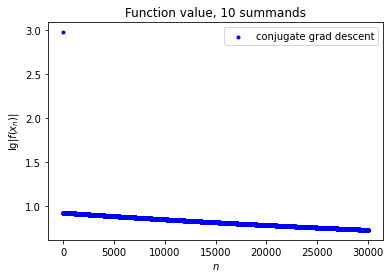

In [ ]:
algrun.plot_func('Function value, 10 summands', log=True)

Эксперименты с 100 членами разложения

In [ ]:
oracle = Oracle(f, g, np.pi, 100, 100000)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('conjugate grad descent', conjugate_grad_descent, np.zeros(100), oracle.func_grad, alpha=1, N=30000, eps=1e-8)

Выходные данные были обрезаны до нескольких последних строк (5000).
25000 5.759832901154067 0.0009227089148706467
25001 5.759759521899015 0.000922702826630388
25002 5.759686144570479 0.0009226967385098006
25003 5.75961276916838 0.0009226906505088808
25004 5.759539395692646 0.0009226845626276247
25005 5.759466024143199 0.0009226784748660284
25006 5.7593926545199645 0.0009226723872240878
25007 5.759319286822865 0.0009226662997017989
25008 5.759245921051823 0.0009226602122991578
25009 5.759172557206767 0.0009226541250161609
25010 5.759099195287618 0.0009226480378528039
25011 5.759025835294302 0.0009226419508090831
25012 5.758952477226742 0.0009226358638849947
25013 5.7588791210848616 0.0009226297770805344
25014 5.758805766868586 0.0009226236903956983
25015 5.758732414577839 0.0009226176038304827
25016 5.7586590642125435 0.0009226115173848836
25017 5.758585715772627 0.0009226054310588971
25018 5.758512369258011 0.0009225993448525192
25019 5.758439024668618 0.000922593258765746
25020 5.7583

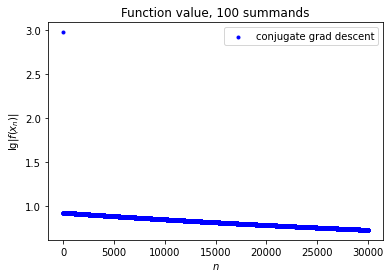

In [ ]:
algrun.plot_func('Function value, 100 summands', log=True)

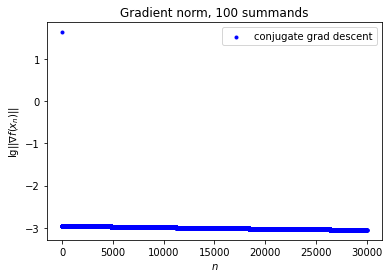

In [ ]:
algrun.plot_grads('Gradient norm, 100 summands', log=True)

In [ ]:
algrun.print_data()

Experiment 'conjugate grad descent': total time 24.788378715515137 seconds;
gradient called 30000 times, function called 30000 times;
minimal gradient norm is 0.0008936914691916459, minimal function value is 5.415594748379247


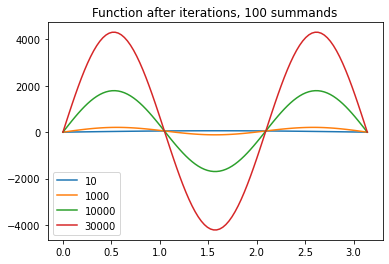

In [ ]:
plt.title('Function after iterations, 100 summands')
plot_Fourier(algrun.results['conjugate grad descent']['points'][10], 100, '10')
plot_Fourier(algrun.results['conjugate grad descent']['points'][1000], 100, '1000')
plot_Fourier(algrun.results['conjugate grad descent']['points'][10000], 100, '10000')
plot_Fourier(algrun.results['conjugate grad descent']['points'][-1], 100, '30000')
#plt.plot(x, algrun.results['conjugate grad descent']['points'][10], label='10')
#plt.plot(x, algrun.results['conjugate grad descent']['points'][1000], label='1000')
#plt.plot(x, algrun.results['conjugate grad descent']['points'][5000], label='5000')
#plt.plot(x, algrun.results['conjugate grad descent']['points'][-1], label='10000')
plt.legend()

Эксперименты с 1000 членами разложения

In [ ]:
oracle = Oracle(f, g, np.pi, 1000, 100000)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('conjugate grad descent', conjugate_grad_descent, np.zeros(1000), oracle.func_grad, alpha=1, N=30000, eps=1e-8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in cosh


Выходные данные были обрезаны до нескольких последних строк (5000).
25000 5.759832905794626 0.0009227089148706467
25001 5.759759526539575 0.000922702826630388
25002 5.7596861492110385 0.0009226967385098006
25003 5.759612773808939 0.0009226906505088808
25004 5.759539400333206 0.0009226845626276247
25005 5.759466028783759 0.0009226784748660284
25006 5.7593926591605245 0.0009226723872240878
25007 5.759319291463425 0.0009226662997017989
25008 5.759245925692383 0.0009226602122991578
25009 5.759172561847326 0.0009226541250161609
25010 5.759099199928178 0.0009226480378528039
25011 5.7590258399348615 0.0009226419508090831
25012 5.7589524818673015 0.0009226358638849947
25013 5.7588791257254215 0.0009226297770805344
25014 5.758805771509146 0.0009226236903956983
25015 5.758732419218399 0.0009226176038304827
25016 5.758659068853103 0.0009226115173848836
25017 5.758585720413187 0.0009226054310588971
25018 5.758512373898571 0.0009225993448525192
25019 5.758439029309178 0.000922593258765746
25020 5.7

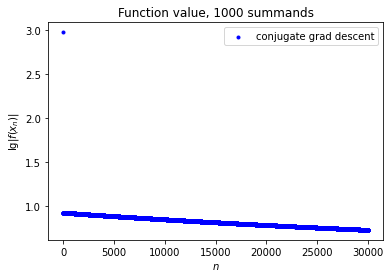

In [ ]:
algrun.plot_func('Function value, 1000 summands', log=True)

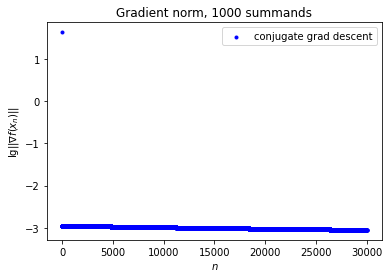

In [ ]:
algrun.plot_grads('Gradient norm, 1000 summands', log=True)

In [ ]:
algrun.print_data()

Experiment 'conjugate grad descent': total time 46.096638679504395 seconds;
gradient called 30000 times, function called 30000 times;
minimal gradient norm is 0.0008936914691916459, minimal function value is 5.415594753019807


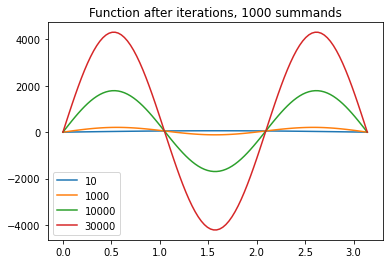

In [ ]:
plt.title('Function after iterations, 1000 summands')
plot_Fourier(algrun.results['conjugate grad descent']['points'][10], 100, '10')
plot_Fourier(algrun.results['conjugate grad descent']['points'][1000], 100, '1000')
plot_Fourier(algrun.results['conjugate grad descent']['points'][10000], 100, '10000')
plot_Fourier(algrun.results['conjugate grad descent']['points'][-1], 100, '30000')
plt.legend()

Эксперименты с 10000 слагаемыми

In [ ]:
oracle = Oracle(f, g, np.pi, 10000, 100000)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('conjugate grad descent', conjugate_grad_descent, np.zeros(10000), oracle.func_grad, alpha=1, N=30000, eps=1e-8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in cosh


Выходные данные были обрезаны до нескольких последних строк (5000).
25000 5.759832905887338 0.0009227089148706467
25001 5.759759526632287 0.000922702826630388
25002 5.759686149303748 0.0009226967385098006
25003 5.759612773901651 0.0009226906505088808
25004 5.7595394004259175 0.0009226845626276247
25005 5.75946602887647 0.0009226784748660284
25006 5.759392659253236 0.0009226723872240878
25007 5.759319291556136 0.0009226662997017989
25008 5.759245925785094 0.0009226602122991578
25009 5.759172561940038 0.0009226541250161609
25010 5.759099200020889 0.0009226480378528039
25011 5.759025840027572 0.0009226419508090831
25012 5.758952481960013 0.0009226358638849947
25013 5.758879125818133 0.0009226297770805344
25014 5.758805771601856 0.0009226236903956983
25015 5.7587324193111105 0.0009226176038304827
25016 5.758659068945815 0.0009226115173848836
25017 5.758585720505898 0.0009226054310588971
25018 5.758512373991282 0.0009225993448525192
25019 5.758439029401889 0.000922593258765746
25020 5.75836

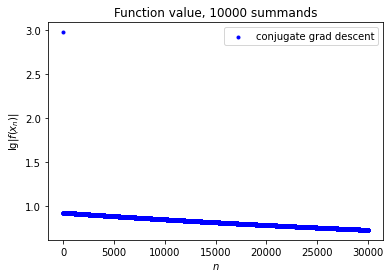

In [ ]:
algrun.plot_func('Function value, 10000 summands', log=True)

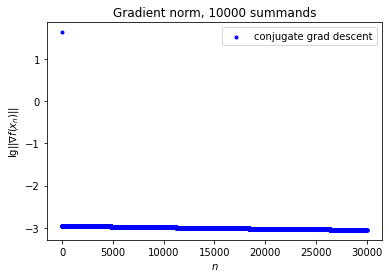

In [ ]:
algrun.plot_grads('Gradient norm, 10000 summands', log=True)

In [ ]:
algrun.print_data()

Experiment 'conjugate grad descent': total time 57.30894422531128 seconds;
gradient called 30000 times, function called 30000 times;
minimal gradient norm is 0.0008936914691916459, minimal function value is 5.415594753112518


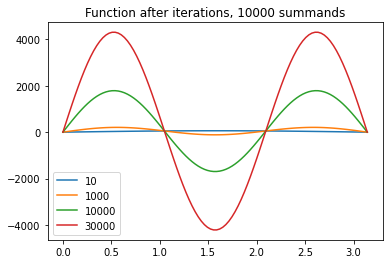

In [ ]:
plt.title('Function after iterations, 10000 summands')
plot_Fourier(algrun.results['conjugate grad descent']['points'][10], 100, '10')
plot_Fourier(algrun.results['conjugate grad descent']['points'][1000], 100, '1000')
plot_Fourier(algrun.results['conjugate grad descent']['points'][10000], 100, '10000')
plot_Fourier(algrun.results['conjugate grad descent']['points'][-1], 100, '30000')
plt.legend()

In [ ]:
def STM(x0, func_grad, verbose=True, L=1, N=1000):
    A = [1/L]
    alpha = [1/L]

    x, xvals, fvals, grads, ngrads, tildaxs, tildagrads, zs = x0.copy().astype(np.float), [], [], [], [], [], [], []
    xvals.append(x)
    f, g = func_grad(xvals[0])
    fvals.append(f)
    ng = norm(g)
    if verbose:
        print(0, f, ng)
    ngrads.append(ng)
    grads.append(g)
    tildaxs.append(x)
    tildagrads.append(func_grad(x)[1])
    zs.append(x - tildagrads[0] * alpha[0])
    xvals.append(zs[0])
    f, g = func_grad(xvals[1])
    fvals.append(f)
    ng = norm(g)
    if verbose:
        print(0, f, ng)
    ngrads.append(ng)
    grads.append(g)
    for i in range(1, N + 1):
        alpha.append(0.5/L + np.sqrt(A[-1] + 0.25/L/L))
        A.append(A[-1] + alpha[-1])
        tildaxs.append((xvals[-1] * A[-2] + zs[-1] * alpha[-1]) / A[-1])
        tildagrads.append(func_grad(tildaxs[-1])[1])
        zs.append(zs[-1] - tildagrads[-1] * alpha[-1])
        xvals.append((xvals[-1] * A[-2] + zs[-1] * alpha[-1]) / A[-1])
        f, g = func_grad(xvals[-1])
        fvals.append(f)
        ng = norm(g)
        if verbose:
            print(i, f, ng)
        ngrads.append(ng)
        grads.append(g)
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': N + 1, 
            'func_count': 0}

Эксперименты с 100 членами разложения

In [ ]:
oracle = Oracle(f, g, np.pi, 100, 100000)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('STM', STM, np.zeros(100), oracle.func_grad, N=1000000)

Выходные данные были обрезаны до нескольких последних строк (5000).
995001 0.1917390775523729 4.293414618073513e-07
995002 0.1917390628216702 4.293718978625014e-07
995003 0.1917390480908461 4.2940231258549013e-07
995004 0.19173903335990042 4.2943270597183226e-07
995005 0.19173901862883325 4.294630780164734e-07
995006 0.1917390038976444 4.294934287147901e-07
995007 0.19173898916633392 4.2952375806187557e-07
995008 0.19173897443490168 4.2955406605339744e-07
995009 0.1917389597033477 4.2958435268431037e-07
995010 0.19173894497167185 4.296146179502868e-07
995011 0.19173893023987418 4.296448618461433e-07
995012 0.19173891550795458 4.2967508436727066e-07
995013 0.19173890077591296 4.297052855094915e-07
995014 0.1917388860437493 4.297354652673432e-07
995015 0.19173887131146358 4.297656236366531e-07
995016 0.19173885657905573 4.297957606125356e-07
995017 0.1917388418465257 4.298258761902504e-07
995018 0.1917388271138734 4.298559703652026e-07
995019 0.19173881238109883 4.298860431326569e-07
995

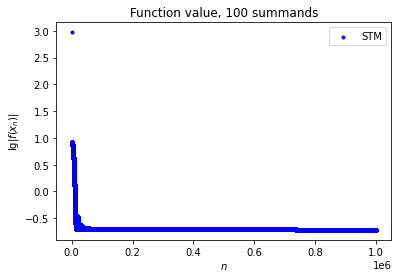

In [ ]:
algrun.plot_func('Function value, 100 summands', log=True)

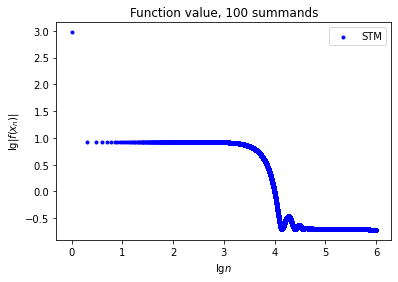

In [ ]:
algrun.plot_func('Function value, 100 summands', log=True, logx=True)

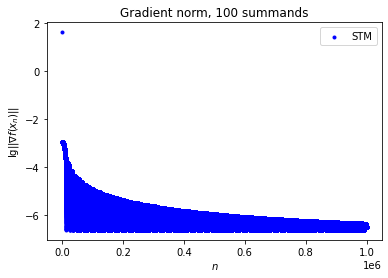

In [ ]:
algrun.plot_grads('Gradient norm, 100 summands', log=True)

In [ ]:
algrun.print_data()

Experiment 'STM': total time 798.9222376346588 seconds;
gradient called 1000001 times, function called 0 times;
minimal gradient norm is 2.4392982014346734e-07, minimal function value is 0.1916638514194737


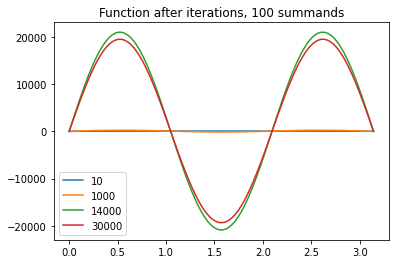

In [ ]:
plt.title('Function after iterations, 100 summands')
plot_Fourier(algrun.results['STM']['points'][10], 100, '10')
plot_Fourier(algrun.results['STM']['points'][1000], 100, '1000')
plot_Fourier(algrun.results['STM']['points'][14000], 100, '14000')
plot_Fourier(algrun.results['STM']['points'][30000], 100, '30000')
plt.legend()

Эксперименты с 1000 членами разложения

In [ ]:
oracle = Oracle(f, g, np.pi, 1000, 100000)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('STM', STM, np.zeros(1000), oracle.func_grad, N=60000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in cosh


Выходные данные были обрезаны до нескольких последних строк (5000).
55001 0.2046264377042983 2.8662057975796697e-05
55002 0.20462515549128876 2.8658635255946488e-05
55003 0.2046238726801078 2.8655210529211468e-05
55004 0.20462258927116264 2.8651783795960414e-05
55005 0.20462130526486083 2.864835505656197e-05
55006 0.20462002066160961 2.8644924311384385e-05
55007 0.20461873546181675 2.864149156079681e-05
55008 0.20461744966589004 2.863805680516804e-05
55009 0.20461616327423748 2.8634620044867555e-05
55010 0.204614876287267 2.8631181280264153e-05
55011 0.2046135887053868 2.862774051172732e-05
55012 0.2046123005290054 2.862429773962672e-05
55013 0.20461101175853114 2.8620852964331843e-05
55014 0.2046097223943728 2.8617406186212693e-05
55015 0.20460843243693894 2.8613957405638762e-05
55016 0.2046071418866387 2.8610506622980403e-05
55017 0.20460585074388082 2.8607053838607284e-05
55018 0.20460455900907468 2.8603599052889936e-05
55019 0.20460326668262968 2.860014226619906e-05
55020 0.2046019

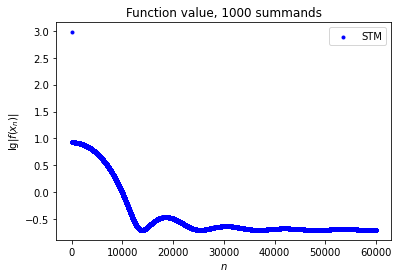

In [ ]:
algrun.plot_func('Function value, 1000 summands', log=True)

In [ ]:
algrun.plot_func('Function value, 1000 summands', log=True, logx=True)

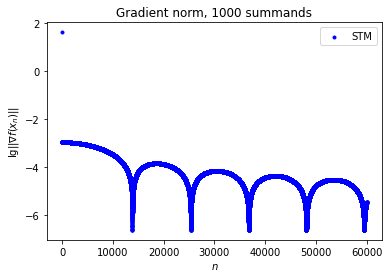

In [ ]:
algrun.plot_grads('Gradient norm, 1000 summands', log=True)

In [ ]:
algrun.print_data()

Experiment 'STM': total time 105.85179352760315 seconds;
gradient called 60001 times, function called 0 times;
minimal gradient norm is 2.4912921542461885e-07, minimal function value is 0.19925741459753948


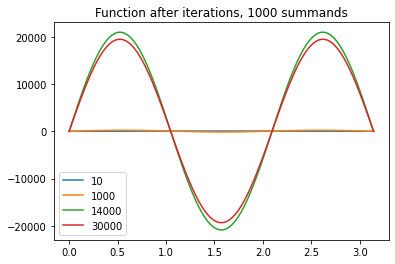

In [ ]:
plt.title('Function after iterations, 1000 summands')
plot_Fourier(algrun.results['STM']['points'][10], 100, '10')
plot_Fourier(algrun.results['STM']['points'][1000], 100, '1000')
plot_Fourier(algrun.results['STM']['points'][14000], 100, '14000')
plot_Fourier(algrun.results['STM']['points'][30000], 100, '30000')
plt.legend()

Эксперименты с 10 слагаемыми

In [ ]:
oracle = Oracle(f, g, np.pi, 10, 100000)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('STM', STM, np.zeros(10), oracle.func_grad, N=10000000)

Выходные данные были обрезаны до нескольких последних строк (5000).
9995001 0.017935676463715192 1.4104854615774211e-08
9995002 0.017935677806366075 1.4105030112729493e-08
9995003 0.01793567914901798 1.4105205982319889e-08
9995004 0.017935680491670915 1.4105382224506216e-08
9995005 0.017935681834324882 1.4105558839222859e-08
9995006 0.017935683176979873 1.410573582638598e-08
9995007 0.01793568451963589 1.4105913185940632e-08
9995008 0.017935685862292938 1.410609091783803e-08
9995009 0.017935687204951017 1.4106269021977251e-08
9995010 0.017935688547610126 1.4106447498343001e-08
9995011 0.017935689890270255 1.4106626346846975e-08
9995012 0.01793569123293142 1.4106805567412938e-08
9995013 0.017935692575593614 1.4106985160000995e-08
9995014 0.01793569391825683 1.4107165124546836e-08
9995015 0.017935695260921074 1.4107345460949911e-08
9995016 0.017935696603586352 1.4107526169193118e-08
9995017 0.017935697946252653 1.4107707249163034e-08
9995018 0.017935699288919988 1.4107888700831013e-08
99

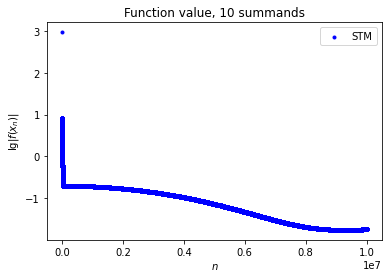

In [ ]:
algrun.plot_func('Function value, 10 summands', log=True)

In [ ]:
algrun.plot_func('Function value, 10 summands', log=True, logx=True)

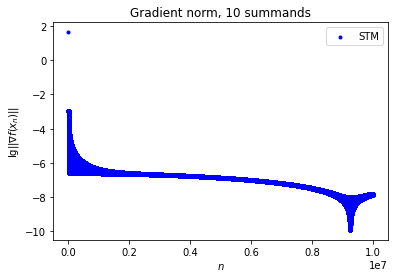

In [ ]:
algrun.plot_grads('Gradient norm, 10 summands', log=True)

In [ ]:
algrun.print_data()

Experiment 'STM': total time 9165.555497407913 seconds;
gradient called 10000001 times, function called 0 times;
minimal gradient norm is 1.2321500917376857e-10, minimal function value is 0.01735805262123337


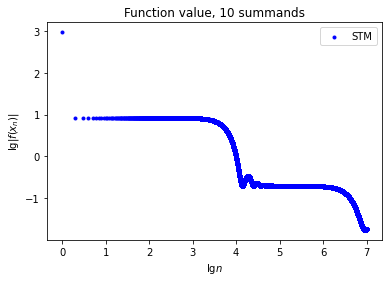

In [ ]:
algrun.plot_func('Function value, 10 summands', log=True, logx=True)

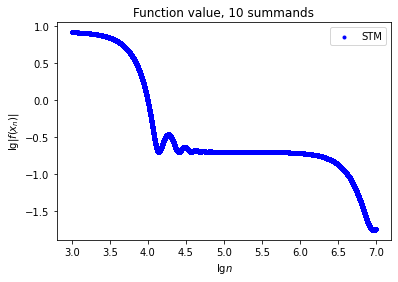

In [ ]:
algrun.plot_func('Function value, 10 summands', log=True, logx=True, n_start=1000)

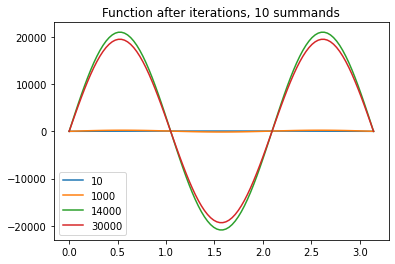

In [ ]:
plt.title('Function after iterations, 10 summands')
plot_Fourier(algrun.results['STM']['points'][10], 100, '10')
plot_Fourier(algrun.results['STM']['points'][1000], 100, '1000')
plot_Fourier(algrun.results['STM']['points'][14000], 100, '14000')
plot_Fourier(algrun.results['STM']['points'][30000], 100, '30000')
plt.legend()

In [ ]:
def f(x):
    return np.sin(x * np.pi) + np.sin(x * np.pi * 3) / np.cosh(np.pi * np.sqrt(8))

def g(x):
    return np.sin(x * np.pi * 2) * np.pi * np.sqrt(3) / np.sinh(np.pi * np.sqrt(3))

In [ ]:
oracle = Oracle(f, g, np.pi, 3, 100000)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('STM', STM, np.zeros(3), oracle.func_grad, N=60000)

Выходные данные были обрезаны до нескольких последних строк (5000).
55001 1.3092534776246222e-11 1.7546195330520633e-09
55002 1.3089410764685751e-11 1.7545369122701495e-09
55003 1.3086284218763976e-11 1.7544081816333179e-09
55004 1.3083155139559122e-11 1.7542333346764426e-09
55005 1.3080023528473645e-11 1.7540123751525343e-09
55006 1.3076889387232618e-11 1.7537453169869966e-09
55007 1.307375271788367e-11 1.7534321843013042e-09
55008 1.3070613522797983e-11 1.7530730114115678e-09
55009 1.306747180466769e-11 1.752667842802079e-09
55010 1.3064327566506607e-11 1.7522167331367473e-09
55011 1.306118081164974e-11 1.7517197472643302e-09
55012 1.3058031543751486e-11 1.7511769602049008e-09
55013 1.3054879766785217e-11 1.7505884571239755e-09
55014 1.3051725485043056e-11 1.7499543333945073e-09
55015 1.3048568703133416e-11 1.7492746945084608e-09
55016 1.3045409425980606e-11 1.7485496561389871e-09
55017 1.3042247658823427e-11 1.7477793440960916e-09
55018 1.3039083407214671e-11 1.7469638943513994e-09


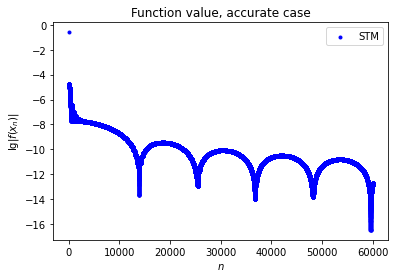

In [ ]:
algrun.plot_func('Function value, accurate case', log=True)

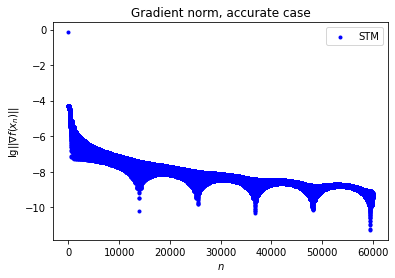

In [ ]:
algrun.plot_grads('Gradient norm, accurate case', log=True)

In [ ]:
algrun.print_data()

Experiment 'STM': total time 55.20704746246338 seconds;
gradient called 60001 times, function called 0 times;
minimal gradient norm is 5.3075543747670445e-12, minimal function value is 3.4181159710388845e-17


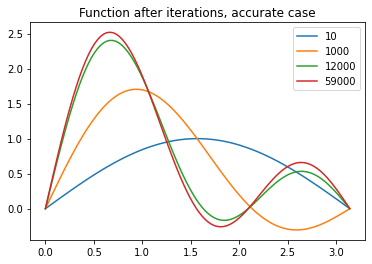

In [ ]:
plt.title('Function after iterations, accurate case')
plot_Fourier(algrun.results['STM']['points'][10], 100, '10')
plot_Fourier(algrun.results['STM']['points'][1000], 100, '1000')
plot_Fourier(algrun.results['STM']['points'][12000], 100, '12000')
plot_Fourier(algrun.results['STM']['points'][59000], 100, '59000')
plt.legend()

In [ ]:
algrun.results['STM']['points'][59526]

array([1.00000563, 0.99846853, 1.02666903])

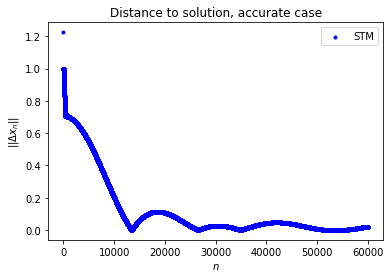

In [ ]:
algrun.plot_distance('Distance to solution, accurate case', x_target=np.ones(3))

In [ ]:
def STM_half(x0, func_grad, verbose=True, L=1, N=1000, beta=0.5):
    A = [1/L]
    alpha = [1/L]
    f_count, g_count = 2, 1

    x, xvals, fvals, grads, ngrads, tildaxs, tildagrads, zs = x0.copy().astype(np.float), [], [], [], [], [], [], []
    f_start, _ = func_grad(x)
    if verbose:
        print('f start', f_start)
    threshold = f_start * beta

    tildaxs.append(x)
    tildagrads.append(func_grad(x)[1])
    zs.append(x - tildagrads[0] * alpha[0])
    xvals.append(zs[0])
    f, g = func_grad(xvals[0])
    fvals.append(f)
    ng = norm(g)
    if verbose:
        print(0, f, ng)
    ngrads.append(ng)
    grads.append(g)
    for i in range(1, N + 1):
        alpha.append(0.5/L + np.sqrt(A[-1] + 0.25/L/L))
        A.append(A[-1] + alpha[-1])
        tildaxs.append((xvals[-1] * A[-2] + zs[-1] * alpha[-1]) / A[-1])
        tildagrads.append(func_grad(tildaxs[-1])[1])
        zs.append(zs[-1] - tildagrads[-1] * alpha[-1])
        xvals.append((xvals[-1] * A[-2] + zs[-1] * alpha[-1]) / A[-1])
        f, g = func_grad(xvals[-1])
        fvals.append(f)
        ng = norm(g)
        if verbose:
            print(i, f, ng)
        ngrads.append(ng)
        grads.append(g)
        f_count += 1
        g_count += 1
        if f < threshold:
            break
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': g_count, 
            'func_count': f_count}

def STM_restart(x0, func_grad, verbose=True, L=1, N_restarts=10, N_on_restart=1000, beta=0.5):
    x, xvals, fvals, grads, ngrads = x0.copy().astype(np.float), [], [], [], []
    xvals.append(x)
    f, g = func_grad(xvals[0])
    fvals.append(f)
    ng = norm(g)
    if verbose:
        print(0, f, ng)
    ngrads.append(ng)
    grads.append(g)
    grad_count = 0
    func_count = 0
    for _ in range(N_restarts):
        result = STM_half(xvals[-1], func_grad, verbose=verbose, L=L, N=N_on_restart, beta=beta)
        xvals += result['points']
        ngrads += result['grad_seq']
        fvals += result['func_seq']
        grad_count += result['grad_count']
        func_count += result['func_count']
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': grad_count, 
            'func_count': func_count}

In [ ]:
oracle = Oracle(f, g, np.pi, 10, 100000)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('STM restart', STM_restart, np.zeros(10), oracle.func_grad, N_restarts=10, N_on_restart=10000)

Выходные данные были обрезаны до нескольких последних строк (5000).
5001 0.19846446727960113 2.201082682387756e-06
5002 0.19846446066948992 2.200855465723125e-06
5003 0.19846445405917756 2.200628219141566e-06
5004 0.19846444744866462 2.2004009426515826e-06
5005 0.19846444083795162 2.2001736362621963e-06
5006 0.19846443422703905 2.1999462999819096e-06
5007 0.19846442761592742 2.199718933818882e-06
5008 0.19846442100461723 2.1994915377819613e-06
5009 0.198464414393109 2.1992641118794796e-06
5010 0.19846440778140326 2.1990366561202846e-06
5011 0.19846440116950048 2.198809170512881e-06
5012 0.1984643945574012 2.1985816550656006e-06
5013 0.1984643879451059 2.1983541097871188e-06
5014 0.19846438133261518 2.1981265346859405e-06
5015 0.19846437471992948 2.1978989297705704e-06
5016 0.19846436810704932 2.1976712950498567e-06
5017 0.19846436149397523 2.197443630531959e-06
5018 0.19846435488070766 2.1972159362257276e-06
5019 0.1984643482672472 2.1969882121398395e-06
5020 0.1984643416535943 2.19676

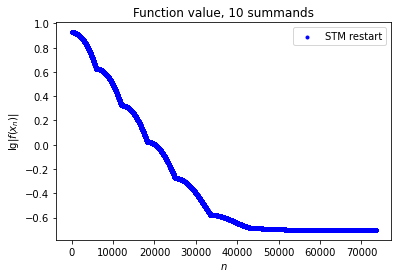

In [ ]:
algrun.plot_func('Function value, 10 summands', log=True, n_start=1)

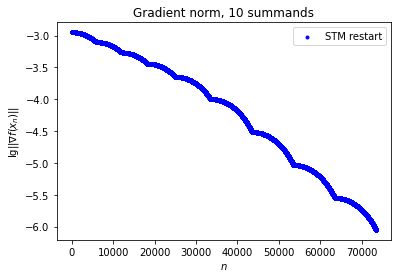

In [ ]:
algrun.plot_grads('Gradient norm, 10 summands', log=True, n_start=1)

In [ ]:
algrun.print_data()

Experiment 'STM restart': total time 60.81742000579834 seconds;
gradient called 73526 times, function called 73536 times;
minimal gradient norm is 8.879589646919407e-07, minimal function value is 0.1984373927324114


In [ ]:
oracle = Oracle(f, g, np.pi, 10, 100000)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('STM restart', STM_restart, np.zeros(10), oracle.func_grad, N_restarts=10, N_on_restart=10000, beta=0.3)

In [ ]:
algrun.plot_func('Function value, 10 summands', log=True, n_start=1)

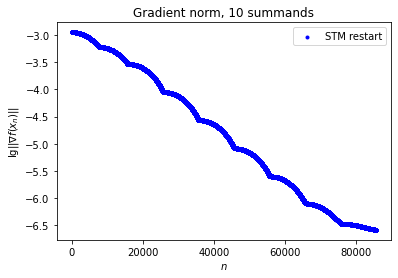

In [ ]:
algrun.plot_grads('Gradient norm, 10 summands', log=True, n_start=1)

In [ ]:
algrun.print_data()

Experiment 'STM restart': total time 70.33864951133728 seconds;
gradient called 85781 times, function called 85791 times;
minimal gradient norm is 2.586468362322702e-07, minimal function value is 0.19843116434696112


In [ ]:
oracle = Oracle(f, g, np.pi, 10, 100000)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('STM restart', STM_restart, np.zeros(10), oracle.func_grad, N_restarts=15, N_on_restart=10000, beta=0.7)

Выходные данные были обрезаны до нескольких последних строк (5000).
5001 0.19845216935584403 1.7322776920843976e-06
5002 0.19845216526431092 1.7321002960490268e-06
5003 0.19845216117264813 1.7319228768023813e-06
5004 0.19845215708085623 1.7317454343516111e-06
5005 0.19845215298893534 1.7315679687035222e-06
5006 0.19845214889688584 1.7313904798649203e-06
5007 0.19845214480470802 1.7312129678424395e-06
5008 0.1984521407124023 1.7310354326430583e-06
5009 0.19845213661996886 1.7308578742732385e-06
5010 0.198452132527408 1.7306802927399594e-06
5011 0.1984521284347202 1.7305026880501986e-06
5012 0.19845212434190565 1.7303250602104191e-06
5013 0.1984521202489647 1.7301474092274278e-06
5014 0.19845211615589767 1.7299697351082031e-06
5015 0.1984521120627048 1.7297920378590366e-06
5016 0.1984521079693865 1.729614317487423e-06
5017 0.19845210387594303 1.7294365739996532e-06
5018 0.19845209978237477 1.7292588074028788e-06
5019 0.1984520956886819 1.7290810177033914e-06
5020 0.19845209159486493 1.72

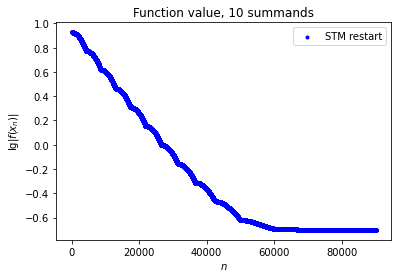

In [ ]:
algrun.plot_func('Function value, 10 summands', log=True, n_start=1)

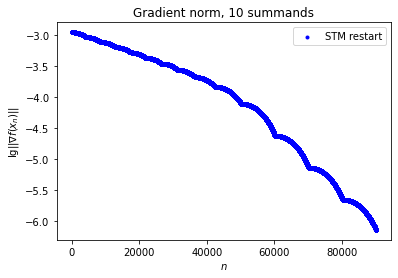

In [ ]:
algrun.plot_grads('Gradient norm, 10 summands', log=True, n_start=1)

In [ ]:
algrun.print_data()

Experiment 'STM restart': total time 75.13766288757324 seconds;
gradient called 90204 times, function called 90219 times;
minimal gradient norm is 7.130250553381966e-07, minimal function value is 0.1984353089229554


In [ ]:
def simple_grad_descent(x0, func_grad, verbose=True, N=1000, alpha=1):
    x, xvals, fvals, grads, ngrads = x0.copy().astype(np.float), [], [], [], []
    xvals.append(x)
    for i in range(N):
        f, g = func_grad(x)
        fvals.append(f)
        ng = norm(g)
        if verbose:
            print(i, f, ng)
        ngrads.append(ng)
        grads.append(g)
        x = x - g * alpha
        xvals.append(x)
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': N, 
            'func_count': 0}

In [ ]:
oracle = Oracle(f, g, np.pi, 10, 100000)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('simple grad descent', simple_grad_descent, np.zeros(10), oracle.func_grad, N=10000000)

Выходные данные были обрезаны до нескольких последних строк (5000).
9995000 1.9887245212177702 0.0005235610728830557
9995001 1.9887242471015838 0.0005235610328010865
9995002 1.9887239729854396 0.0005235609927191203
9995003 1.9887236988693373 0.0005235609526371573
9995004 1.988723424753276 0.0005235609125551972
9995005 1.9887231506372574 0.0005235608724732402
9995006 1.9887228765212803 0.0005235608323912863
9995007 1.9887226024053464 0.0005235607923093355
9995008 1.9887223282894533 0.0005235607522273879
9995009 1.988722054173603 0.0005235607121454433
9995010 1.9887217800577937 0.0005235606720635015
9995011 1.988721505942027 0.000523560631981563
9995012 1.9887212318263017 0.0005235605918996275
9995013 1.988720957710619 0.0005235605518176951
9995014 1.9887206835949787 0.0005235605117357658
9995015 1.9887204094793796 0.0005235604716538395
9995016 1.9887201353638226 0.0005235604315719164
9995017 1.9887198612483077 0.0005235603914899962
9995018 1.9887195871328338 0.0005235603514080791
999501

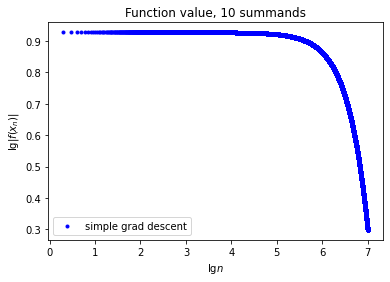

In [ ]:
algrun.plot_func('Function value, 10 summands', log=True, logx=True, n_start=1)

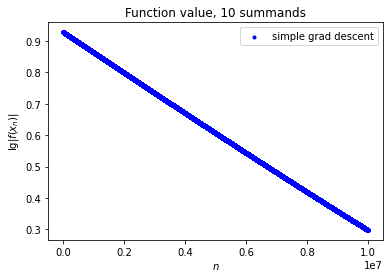

In [ ]:
algrun.plot_func('Function value, 10 summands', log=True, n_start=1)

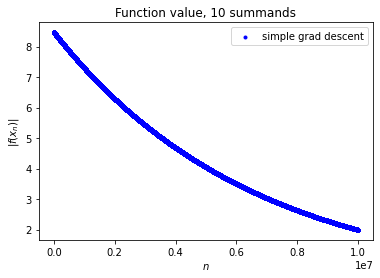

In [ ]:
algrun.plot_func('Function value, 10 summands', n_start=1)